# Password Analysis

Below analyzes 2m passwords hacked from Yahoo and released publicly.  We'll look at the most common password length and characters, as well as popular phrases (love, man, wang, dragon, windows, pass).

As an aside, password length trumps complexity.  Hackers have already catalogued short 8 character passwords into rainbow hash tables as discussed here
https://medium.com/policygenius-stories/the-sophisticates-guide-to-passwords-4bb6b5d9ecb5.

In [2]:
#initialize
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

#multiple outputs per cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

### Import Data

In [15]:
%%time
# df = pd.read_table('http://datashaping.com/passwords.txt',skiprows=16,names=(['pw']),quoting=3)  # nrows=10
df = pd.read_csv('pwAnalysis.csv',usecols=['A'])
df.columns=['pw']
print('passwords = ',"{:,}".format(df.pw.size)
      ,'\ndups = ',df.pw.size - df.pw.unique().size
      ,'\ntotalCharacters = ',"{:,}".format(len(df.pw.str.cat())))

passwords =  2,151,220 
dups =  399 
totalCharacters =  18,011,567
Wall time: 2.4 s


In [4]:
print(df.head())
print(df.tail())

             pw
0   07606374520
1  piontekendre
2      rambo144
3     primoz123
4       sal1387
                  pw
2151215     26778982
2151216      brazer1
2151217   usethisone
2151218  scare222273
2151219     anto1962


### Password Length

most common length:  8.0 characters


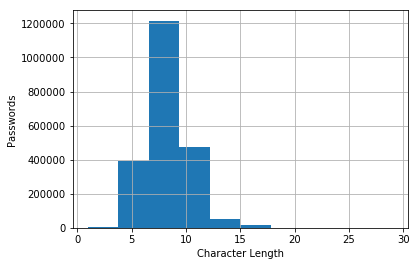

In [4]:
# How many characters do most people use?
df['pwlength']=df.pw.str.len()
pp = df['pwlength'].hist()
z = pp.set_xlabel("Character Length")
z = pp.set_ylabel("Passwords")
print('most common length: ',df['pwlength'].mode().max(), 'characters')

In [5]:
#Look at some of the longest and shortest passwords
print(df.sort_values(by='pwlength',ascending=False).head())
print(df.sort_values(by='pwlength').head())

                                    pw  pwlength
120304   waaaaaaaaaaaaaaaaaaaaaaaaaaaa      29.0
1155769  @fytEm10 *Vb^mZ3%100iRt3h1337      29.0
1165598  babi punyer encryptor haihhhh      29.0
254206   IhanVitunPitkaSalasanaSaakeli      29.0
457967   a42bdef285d431054f2848d30afac      29.0
        pw  pwlength
358891   a       1.0
1688806  9       1.0
1078081  7       1.0
622400   Y       1.0
1266307  J       1.0


### Characters Used

In [6]:
# what alpha character is most often used?
import nltk

def printMostCommon(n):
    df2 = pd.DataFrame(fdist.most_common(n))
    df2.columns = ['char','freq']
    df2['occurence']= df2.freq / len(df.pw.str.cat()) # % of all characters
    return df2
    
fdist = nltk.FreqDist(ch.lower() for ch in df.pw.str.cat() if ch.isalpha())
printMostCommon(3)[['char','occurence']]

,char,occurence
0,a,0.059467
1,e,0.045304
2,i,0.040045


In [8]:
#most common digits
fdist = nltk.FreqDist(ch.lower() for ch in df.pw.str.cat() if ch.isdigit())
print(printMostCommon(10)[['char','occurence']].to_string(index=False))

char  occurence
  1   0.070659
  0   0.055075
  2   0.052167
  3   0.040011
  8   0.039114
  9   0.037986
  5   0.036266
  6   0.033089
  7   0.031876
  4   0.031412


In [10]:
#most common special character
fdist = nltk.FreqDist(ch.lower() for ch in df.pw.str.cat() if not ch.isalnum())
printMostCommon(8)[['char','occurence']]

,char,occurence
0,.,0.001021
1,@,0.000675
2,!,0.000595
3,-,0.000428
4,_,0.000423
5,*,0.000357
6,#,0.000260
7,,0.000232


In [12]:
# how often are special case used?
df['specialChar']=df.pw.apply(lambda s: not str(s).isalnum())
print('people use special characters ', "{:%}".format(df.pw[df['specialChar']==True].size / df.pw.size),'of the time')

people use special characters  3.104471% of the time


### Common Phrases

In [13]:
#how many contain certain string
s = 'pass'
print('people use ',s,
      "{:%}".format(df[df.pw.str.lower().str.match(s,na=False)].size / df.size),' of the time')

df[df.pw.str.lower().str.match(s,na=False)].pw.head(25).str.cat(sep='|')

people use  pass 0.084231%  of the time


'passme|pass6789|passw<>|passwort24|password@123|pass1990|password-1|passtoefl|passat37|passat12|passwordjoy?|pass2727|pass2431|pass66|passmedearbook|pass4pulse|Passat|password321|passwdCas|password301415|pass9033|passactuel|pass`123|passat10|passcode1013'

In [33]:
# what character combo is most often used?

import re
from collections import Counter
import datetime

# trace progress as it runs
def printTimeDuration (msg):
    global dtStart, dtLast
    dtNow = datetime.datetime.now()
    cumDelta = dtNow - dtStart
    curDelta = dtNow - dtLast
    
    hours, remainder = divmod(curDelta.seconds, 3600)
    minutes, seconds = divmod(remainder, 60)

    cumHours, cumRemainder = divmod(cumDelta.seconds, 3600)
    cumMinutes, cumSeconds = divmod(cumRemainder, 60)
    
    print(msg,'incr:','%s:%s:%s' % (hours, minutes, seconds),'ttl:','%s:%s:%s' % (cumHours, cumMinutes, cumSeconds))
    dtLast = dtNow

# return a counter of most common phrases
def mostCommonStrings(charLen,cnt):
    s=df.pw.head(1000).str.cat()

    t = len(s) - (charLen - 1)
    for i in range(t):
        char = s[i:i+charLen]               # a sequence of characters being considered
        allAlpha = True
        for j in range(charLen):
            if not char[j].isalpha():
                allAlpha = False
                break
        if allAlpha:
            numFound = len(re.findall(char,s))
            if numFound>8 and not cnt[char]:    # threshold 8 or more instances
                cnt[char] += numFound

    printTimeDuration('charLen'+str(charLen))
    return cnt

In [44]:
%%time

import numba
from numba import double
from numba.decorators import jit, autojit

# @numba.jit
# def testfn(s):
#     for i in range(len(s)):
#         char = s[i]

def testfn2(s,charLen):
    t = len(s) - (charLen - 1)
    for i in range(t):
        char = s[i:i+charLen]               # a sequence of characters being considered
        allAlpha = True
        for j in range(charLen):
            if not char[j].isalpha():
                allAlpha = False
                break
        if allAlpha:
            numFound = len(re.findall(char,s))
            if numFound>8 and not cnt[char]:    # threshold 8 or more instances
                cnt[char] += numFound
    return cnt



autojit(testfn2(df.pw.head(1000).str.cat(),5))
# testfn2(df.pw.head(1000).str.cat(),5)

TypeError: Counter() is not a callable object

In [19]:
# %load_ext Cython
%reload_ext Cython

%%cython
# def f_plain(x):
#     return x * (x - 1)

SyntaxError: invalid syntax (<ipython-input-19-bff2e6bfbe3e>, line 4)

In [21]:
%%time
dtStart = datetime.datetime.now()
dtLast = dtStart
printTimeDuration('start')
    
cnt = Counter()
for i in range(4,9):
    cnt = mostCommonStrings(i,cnt)

df3 = pd.DataFrame.from_dict(cnt, orient='index').reset_index()
if df3.columns.size==2:
    df3.columns = ['char','freq']
    #df3['freq']=df3.freq.apply(lambda x: math.sqrt(x))
    df3['charLen']=df3.char.apply(lambda str: len(str))
print('records=',df3.size)

start incr: 0:0:0 ttl: 0:0:0
charLen4 incr: 0:0:0 ttl: 0:0:0
charLen5 incr: 0:0:0 ttl: 0:0:0
charLen6 incr: 0:0:0 ttl: 0:0:0
charLen7 incr: 0:0:0 ttl: 0:0:0
charLen8 incr: 0:0:0 ttl: 0:0:0
records= 0
Wall time: 742 ms


In [61]:
print('most common phrases are')
df3.sort_values(['charLen', 'freq'], ascending=[False, False]).head()

most common phrases are


,char,freq,charLen
7734,password,57,8
7736,dearbook,33,8
7735,iloveyou,19,8
7739,computer,12,8
7730,kikugala,11,8


In [ ]:
from nltk.corpus import words
df3['word']=df3.char.apply(lambda m: 1 if m in words.words() else 0)

In [63]:
print('most common words are')
df3[df3.word==True].sort_values(['charLen', 'freq'], ascending=[False, False]).char.head(50).str.cat(sep='|')

most common words are


'password|computer|scorpion|superman|forever|diamond|vincent|welcome|compute|phoenix|freedom|element|dolphin|counter|thunder|master|dragon|killer|victor|monkey|hacker|martin|window|prince|summer|little|beyond|silver|shadow|flower|golden|change|friend|spider|secret|design|orange|purple|buster|soccer|snoopy|legend|matrix|jordan|system|pepper|stella|polska|yellow|junior'

In [37]:
#how often do these phrases appear?
df5 = pd.DataFrame({'char':['love','pass','man','wang','dragon','zzzz','and','123','windows']})
df5['freq']= df5.char.apply(lambda ch: df[df.pw.str.lower().str.match(ch.lower(),na=False)].size)
df5['occurence']= df5.char.apply(lambda ch: df[df.pw.str.lower().str.match(ch.lower(),na=False)].size / df.size)
df5.sort_values(by='freq',ascending=False)

,char,freq,occurence
7,123,35661,0.005526
3,wang,15405,0.002387
0,love,14217,0.002203
2,man,10869,0.001684
6,and,7287,0.001129
1,pass,5436,0.000842
4,dragon,1944,0.000301
8,windows,876,0.000136
5,zzzz,336,0.000052
